Missing values before imputation:
id                           0
log_price                    0
property_type                0
room_type                    0
amenities                    0
accommodates                 0
bathrooms                   51
bed_type                     0
cancellation_policy          0
cleaning_fee                 0
city                         0
description                  0
first_review              4725
host_has_profile_pic        56
host_identity_verified      56
host_response_rate        5475
host_since                  56
instant_bookable             0
last_review               4716
latitude                     0
longitude                    0
name                         0
neighbourhood             2086
number_of_reviews            0
review_scores_rating      4978
zipcode                    303
bedrooms                    26
beds                        35
dtype: int64
Missing values after imputation:
id                        0
log_price               

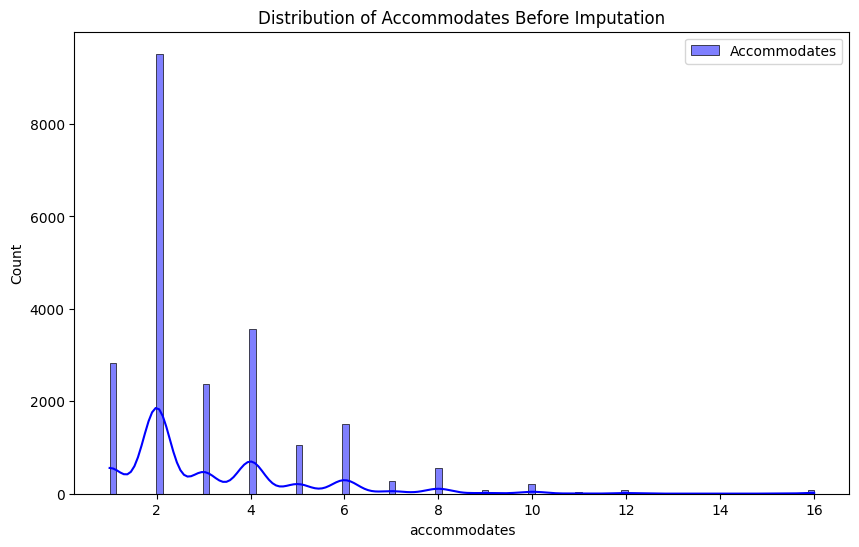

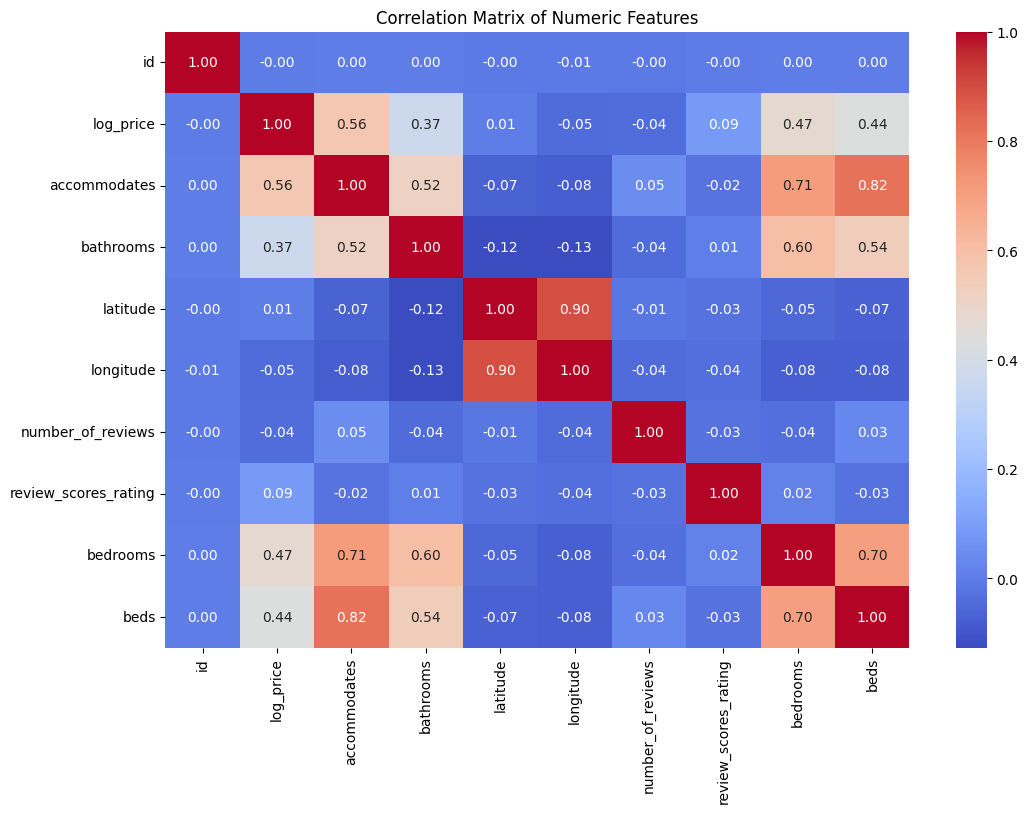

Mean Squared Error: 0.1689907151298987
CSV file 'predictions.csv' has been created successfully.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

# Load data
train_data = pd.read_csv('airbnb_train.csv')
test_data = pd.read_csv('airbnb_test.csv')

# Checking and handling missing values
print("Missing values before imputation:")
print(train_data.isnull().sum())

# Filling missing values
for column in train_data.columns:
    if train_data[column].dtype == object:  # For categorical data
        train_data[column].fillna(train_data[column].mode()[0], inplace=True)
    else:  # For numeric data
        train_data[column].fillna(train_data[column].median(), inplace=True)

for column in test_data.columns:
    if test_data[column].dtype == object:
        test_data[column].fillna(test_data[column].mode()[0], inplace=True)
    else:
        test_data[column].fillna(test_data[column].median(), inplace=True)

print("Missing values after imputation:")
print(train_data.isnull().sum())

# Visualization of data distributions and correlations
plt.figure(figsize=(10, 6))
sns.histplot(train_data['accommodates'].dropna(), kde=True, color='blue', label='Accommodates')
plt.title('Distribution of Accommodates Before Imputation')
plt.legend()
plt.show()

# Only numeric columns for correlation matrix
numeric_cols = train_data.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_cols.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# Use a column like 'Unnamed: 0' as ID if 'id' is not present
test_ids = test_data['Unnamed: 0'].copy()

class CombinedTextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.columns is not None:
            return X[self.columns].agg(' '.join, axis=1).astype(str)
        return X

# Define preprocessing for numeric columns
numeric_features = ['accommodates', 'bathrooms', 'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_features = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city', 'neighbourhood', 'zipcode', 'instant_bookable', 'host_has_profile_pic', 'host_identity_verified']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Define preprocessing for text columns
text_features = ['description', 'name', 'amenities']
text_transformer = Pipeline(steps=[
    ('combine', CombinedTextTransformer(columns=text_features)),
    ('vect', CountVectorizer(stop_words='english', max_features=100))])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', text_transformer, text_features)])

# Define the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

# Split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(train_data.drop(['log_price'], axis=1), train_data['log_price'], test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Validate the model
y_pred = model.predict(X_valid)
print(f'Mean Squared Error: {mean_squared_error(y_valid, y_pred)}')

# Prepare the test set predictions
test_preds = model.predict(test_data.drop('Unnamed: 0', axis=1))

# Create the submission file
submission = pd.DataFrame({'id': test_ids, 'logpred': test_preds})
submission.to_csv('predictions.csv', index=False)

print("CSV file 'predictions.csv' has been created successfully.")
